In [1]:
import pandas as pd
from Forecast import Forecast
import matplotlib.pyplot as plt

In [114]:
time_entries = pd.read_csv('../data/harvest/time_entries.csv', 
                           index_col='id',
                           parse_dates=['created_at', 'spent_date', 'updated_at',
                                        'task_assignment.created_at', 'task_assignment.updated_at', 
                                        'user_assignment.created_at', 'user_assignment.updated_at'],
                           infer_datetime_format=True)

# remove empty columns
time_entries.dropna(axis=1, inplace=True)

time_entries.loc[time_entries['user.name']=='Evelina Gabasova', ['project.name','client.name','task.name','spent_date','hours']].head(20)

,project.name,client.name,task.name,spent_date,hours
id,,,,,
976618782,Professional development,Hut 23,Attend conference,2019-04-05,8.0
976618666,Professional development,Hut 23,Attend conference,2019-04-04,8.0
977753610,Professional development,Hut 23,Conferences and seminars,2019-04-02,2.0
977753438,NATS,Data-centric engineering,Programming,2019-04-02,6.0
976618223,NATS,Data-centric engineering,Programming,2019-04-01,4.0
976618049,NATS,Data-centric engineering,Project Management,2019-04-01,4.0
976617663,NATS,Data-centric engineering,Programming,2019-03-29,8.0
976617574,NATS,Data-centric engineering,Programming,2019-03-28,8.0
976617490,NATS,Data-centric engineering,Programming,2019-03-27,8.0


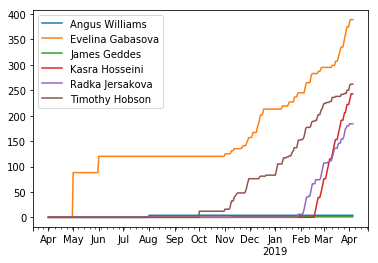

In [38]:
grouped_entries = time_entries.groupby(['project.name', 'user.name','spent_date']).hours.sum()

date_range = pd.date_range(start=time_entries['spent_date'].min(),
                           end=time_entries['spent_date'].max(),
                           freq='D')

entries = {}

id_values = time_entries['project.name'].unique()
ref_column = 'user.name'

for idx in id_values:
    # check whether the this id has any assignments, i.e. whether the id
    # exists in the index (get_level_values to deal with MultiIndex)
    if idx in grouped_entries.index.get_level_values(0):
        # get the entries
        id_entries = grouped_entries.loc[idx]

        # unstack the MultiIndex
        id_entries = id_entries.reset_index()

        # Initialise dataframe to store results
        id_entries_days = pd.DataFrame(index=date_range, columns=id_entries[ref_column].unique())
        id_entries_days.fillna(0, inplace=True)

        # Loop over each assignment
        for _, row in id_entries.iterrows():
            # Add the allocation to the corresponding project for the range of dates.
            id_entries_days.loc[row['spent_date'], row[ref_column]] += row['hours']

    else:
        # no projects, just make an empty dataframe
        id_entries_days = pd.DataFrame(index=date_range)

    entries[idx] = id_entries_days

#entries['NATS'].resample('MS').sum()
entries['NATS'].cumsum().plot()

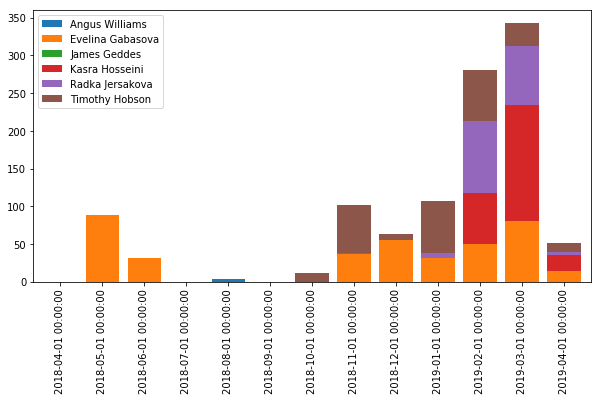

In [104]:
ax = plt.figure(figsize=(10,5)).gca()

entries['NATS'].resample('MS').sum().plot.bar(stacked=True, width=0.8, ax=ax)

In [82]:
nats_harvest = entries['AIDA-Lloyds'].sum(axis=1)

In [117]:
fc = Forecast()

# 5.5 hours / day for projects on average if excluding public holidays and annual leave
# nats_forecast = 5.5*fc.project_reqs[fc.get_project_id('NATS')]

# 223 working days after leave/253 business days (= 0.88): correct adjustment as pub hols + weekends already excluded from Forecast date ranges?
nats_forecast = (223/253)*6.4*fc.project_reqs[fc.get_project_id('NATS')]

# 6.4 hours / day nominal 80% of an 8 hour day
#nats_forecast = 6.4*fc.project_reqs[fc.get_project_id('NATS')]

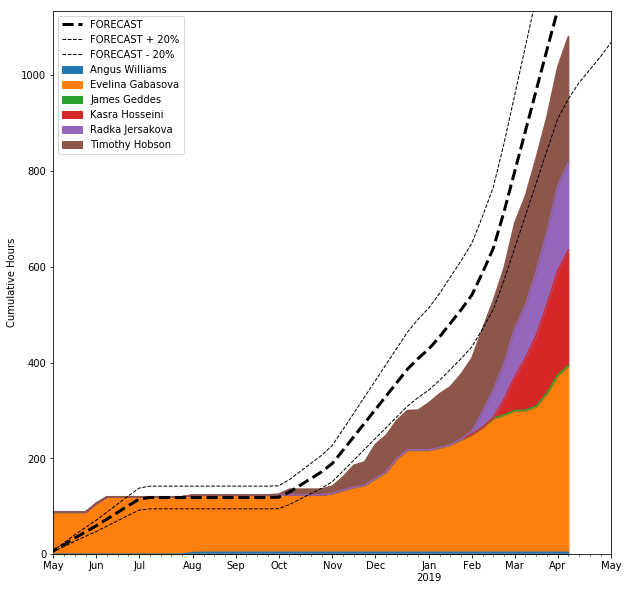

In [118]:
ax = plt.figure(figsize=(10,10)).gca()
entries['NATS'].cumsum().resample('W-MON').mean().plot.area(ax=ax)

fc_cumsum = nats_forecast.cumsum().resample('W-MON').mean()
fc_cumsum.plot(linestyle='--', linewidth=3, color='k', label='FORECAST')
(1.2*fc_cumsum).plot(linestyle='--', linewidth=1, color='k', label='FORECAST + 20%')
(0.8*fc_cumsum).plot(linestyle='--', linewidth=1, color='k', label='FORECAST - 20%')

plt.xlim([pd.datetime(2018,5,1), pd.datetime(2019,5,1)])
plt.ylabel('Cumulative Hours')
plt.legend()

(0, 1500)

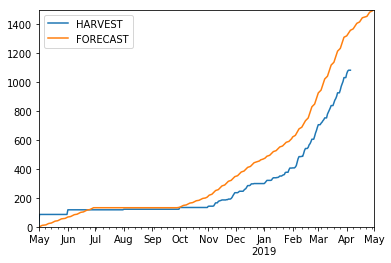

In [54]:
nats_harvest.cumsum().plot(label='HARVEST')
nats_forecast.cumsum().plot(label='FORECAST')

plt.xlim([pd.datetime(2018,5,1), pd.datetime(2019,5,1)])
plt.legend()
plt.ylim([0, 1500])

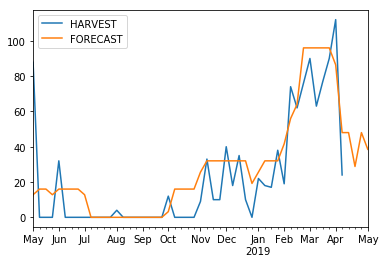

In [56]:
nats_harvest.resample('W-MON').sum().plot(label='HARVEST')
nats_forecast.resample('W-MON').sum().plot(label='FORECAST')
plt.xlim([pd.datetime(2018,5,1), pd.datetime(2019,5,1)])
plt.legend()


## Excluding weekends and public holidays

In [12]:
#!pip install holidays
import holidays

uk_holidays = holidays.England()

pd.datetime(2023,8,28) in uk_holidays

tmp = pd.date_range('2019-01-01','2019-12-31')
print('all days',len(tmp))

tmp = pd.date_range('2019-01-01','2019-12-31', freq=pd.tseries.offsets.BDay())
print('weekdays',len(tmp))

tmp = pd.date_range('2019-01-01','2019-12-31', freq=pd.tseries.offsets.BDay())
tmp = [x for x in tmp if x not in uk_holidays]
print('business days',len(tmp))

tmp = pd.to_datetime(tmp)

all days 365
weekdays 261
business days 253
